# Preparation for ERC v2

In [ ]:
!pip3 install transformers==4.12.5
!pip3 install torch==1.10.0
!pip3 install torchtext==0.11.0

In [ ]:
import os
from google.colab import drive

import string
import random
import csv

import torch
import torch.nn as nn

import ipywidgets as widgets
from IPython.display import display as widgets_display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn

from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset, BucketIterator, Iterator

from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
working_path = '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC'

### Mount the drive

In [ ]:
global drivemount_status
drivemount_status = True if os.path.isdir('/content/drive/MyDrive') else False

global erc_root_folder
erc_root_folder = (working_path + '/Root') if drivemount_status else '/content'

global model_temp_folder
model_temp_folder = (working_path + '/Model_Temp') if drivemount_status else '/content'

In [ ]:
drivemount_button = widgets.Button()
drivemount_output = widgets.Output()

with drivemount_output:
    if drivemount_status:
        print('It is now mounted!')
        drivemount_button.description = '🔴 Unmount'
    else:
        print('It is not mounted yet. Click button to mount!')
        drivemount_button.description = '🚀 Mount'

def drivemount_button_onclick(b):
    global drivemount_status
    global model_temp_folder
    global erc_root_folder

    with drivemount_output:
        drivemount_output.clear_output()
        if drivemount_status:
            drive.flush_and_unmount()
            erc_root_folder = '/content'
            model_temp_folder = '/content'
            model_temp_folder = model_temp_folder.rstrip('/')
            drivemount_button.description = '🚀 Mount'
            drivemount_status = False
            print('[UNMOUNTED] It is unmounted right now.')
        else:
            print('[MOUNTING] Please wait...')
            drive.mount('/content/drive')
            erc_root_folder = working_path + '/Root'
            model_temp_folder = working_path + '/Model_Temp'
            model_temp_folder = model_temp_folder.rstrip('/')
            drivemount_button.description = '🔴 Unmount'
            drivemount_status = True
            print('[MOUNTED] Hurrah! It is now mounted!')

drivemount_button.on_click(drivemount_button_onclick)

widgets_display(drivemount_button, drivemount_output)

Button(description='🔴 Unmount', style=ButtonStyle())

Output()

# ERC Tokenizer - v2 (with BERT)

Before implementing the BERT support, we use pure text to be the token in training. I hope BERT can help us normalizing the matrix and improving the training result.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Parameters preparation.
MAX_SENT_LENGTH = 128
PAD_TOKEN_ID = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

def normalize_v2(text, entity):
    text = text.lower()
    entity = entity.lower()
    if entity not in text:
        return text
    text = text.replace(entity, tokenizer.mask_token) # TODO: not sure if this will be decoded by BERT.
    return text

### Data Preprocessing Module

Use `data_preprocess(erc_raw_data)` to preprocess the given data into csv files (no return).

In [ ]:
def data_preprocess(ercdata_raw, ercdata_raw_null,
                    root_path=erc_root_folder,
                    training_portion=0.85,
                    validation_portion=0.05,
                    testing_portion=0.10):
    root_path = root_path.rstrip('/')

    # make sure that they are summing up to 1.
    assert training_portion + validation_portion + testing_portion == 1.0

    # open up writers.
    dpre_train_writer = open(root_path + '/dpre_training_data.csv', 'w')
    dpre_valid_writer = open(root_path + '/dpre_validation_data.csv', 'w')
    dpre_test_writer = open(root_path + '/dpre_testing_data.csv', 'w')

    dpre_train_csv_writer = csv.writer(dpre_train_writer, delimiter=',')
    dpre_valid_csv_writer = csv.writer(dpre_valid_writer, delimiter=',')
    dpre_test_csv_writer = csv.writer(dpre_test_writer, delimiter=',')

    # write the header.
    dpre_header = ['text', 'label']
    dpre_train_csv_writer.writerow(dpre_header)
    dpre_valid_csv_writer.writerow(dpre_header)
    dpre_test_csv_writer.writerow(dpre_header)

    conflicts_count = 0

    processed_rows = []

    for i in range(len(ercdata_raw)):
        # detect if it is conflict.
        curr_label = ercdata_raw['finalized_label(is_referring)'].iloc[i]
        if curr_label == '[conflict occurring!]': # conflict label processed by annotation system.
            conflicts_count += 1
            continue

        # detect if it is null.
        curr_isnull = ercdata_raw_null['finalized_label(is_referring)'].iloc[i]
        if curr_isnull:
            continue
        
        # extract the data if it passes all validation tests.
        curr_data = normalize_v2(ercdata_raw['text'].iloc[i].lower(), ercdata_raw['target'].iloc[i].lower())
        curr_label = 1 if curr_label == 'True' else 0

        # buildup the data row.
        processed_rows.append([curr_data, curr_label])
    
    # shuffle the raw data.
    random.shuffle(processed_rows)

    len_rows = len(processed_rows)
    dpre_train_size = int(len_rows * training_portion)
    dpre_valid_size = dpre_train_size + int(len_rows * validation_portion)
    dpre_test_size = dpre_valid_size + int(len_rows * testing_portion)

    raw_train_range = range(dpre_train_size)
    raw_valid_range = range(dpre_train_size, dpre_valid_size)
    raw_test_range = range(dpre_valid_size, dpre_test_size)

    for i in range(len_rows):
        if i in raw_train_range:
            dpre_train_csv_writer.writerow(processed_rows[i])
        elif i in raw_valid_range:
            dpre_valid_csv_writer.writerow(processed_rows[i])
        elif i in raw_test_range:
            dpre_test_csv_writer.writerow(processed_rows[i])

    dpre_train_writer.close()
    dpre_valid_writer.close()
    dpre_test_writer.close()

    print('[DATA_PREPROCESSING] DONE! Raw data has {} conflicts in total.'.format(conflicts_count))

In [ ]:
def make_dataset(ercdata_raw_path=erc_root_folder+'/mix_data.csv'):
    ercdata_raw = pd.read_csv(ercdata_raw_path)
    ercdata_raw_null = ercdata_raw.isnull()

    data_preprocess(ercdata_raw, ercdata_raw_null)

    dpre_f_text = data.Field(use_vocab=False,
                             tokenize=tokenizer.encode,
                             lower=False,
                             include_lengths=False,
                             batch_first=True,
                             fix_length=MAX_SENT_LENGTH,
                             pad_token=PAD_TOKEN_ID)

    dpre_f_label = data.Field(sequential=False, # no tokenization will take place on the label.
                              use_vocab=False,
                              batch_first=True,
                              dtype=torch.int8)

    dpre_fields = [('text', dpre_f_text), ('label', dpre_f_label)]

    dpre_fields_dict = {
        'text': ('text', dpre_f_text),
        'label': ('label', dpre_f_label)
    }

    train_set, valid_set, test_set = TabularDataset.splits(path=erc_root_folder, train='dpre_training_data.csv',
                                                           validation='dpre_validation_data.csv',
                                                           test='dpre_testing_data.csv',
                                                           format='CSV', fields=dpre_fields,
                                                           skip_header=True)
    
    print('[MAKE_DATASET] Training, validation, and testing datasets are ready to go!')
    print('[MAKE_DATASET] Dataset size - [TRAIN: {}, VALID: {}, TEST: {}].'.format(len(train_set), len(valid_set), len(test_set)))
    print('[MAKE_DATASET] DONE! Enjoy it~')

    return train_set, valid_set, test_set

# ERC BERT Core Model (`ERCBCM`) - v2

In this core model, we are using `BertForSequenceClassification` as a base.

In [ ]:
class ERCBCM(nn.Module):

    def __init__(self):
        super(ERCBCM, self).__init__()

        self.bert_base = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    def forward(self, text, label):
        loss, text_fea = self.bert_base(text, labels=label)[:2]
        return loss, text_fea

In [ ]:
# Save and Load Functions.

def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print('[SAVE] Model has been saved successfully to \'{}\''.format(save_path))

def load_checkpoint(load_path, model):
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print('[LOAD] Model has been loaded successfully from \'{}\''.format(load_path))
    model.load_state_dict(state_dict['model_state_dict'], strict=False)
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print('[SAVE] Model with matrics has been saved successfully to \'{}\''.format(save_path))

def load_metrics(load_path):
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print('[LOAD] Model with matrics has been loaded successfully from \'{}\''.format(load_path))
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# Main Program of ERC v2

We are going to finish these objectives in v2:
- BERT Embeddings.
- Dataset Splittings.
- Live Testing.

In [ ]:
# control panel.

run_for_training = True  # Toggle it on to train the model.

### Make the dataset

In [ ]:
# Make the dataset from raw data.
#  We need this step even if it is for evaluating only.
train_set, valid_set, test_set = make_dataset()

[DATA_PREPROCESSING] DONE! Raw data has 4 conflicts in total.
[MAKE_DATASET] Training, validation, and testing datasets are ready to go!
[MAKE_DATASET] Dataset size - [TRAIN: 850, VALID: 50, TEST: 100].
[MAKE_DATASET] DONE! Enjoy it~


In [ ]:
train_iter = BucketIterator(train_set, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_set, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test_set, batch_size=16, device=device, train=False, shuffle=False, sort=False)

### Start training

We do not need to train it again (e.g. after changing parameters), avoid re-training all the times.

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 8,
          eval_every = len(train_iter) // 2,
          file_path = model_temp_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            text = text.type(torch.LongTensor)
            text = text.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values.
            running_loss += loss.item()
            global_step += 1

            # evaluation step.
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # validation loop
                    for (text, labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)
                        labels = labels.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    model.eval() # stop training.

if run_for_training:
    model = ERCBCM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    train(model=model, optimizer=optimizer)
else:
    print('Not run for training. Skip.')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/8], Step [27/432], Train Loss: 0.6564, Valid Loss: 0.4187
[SAVE] Model has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/model.pt'
[SAVE] Model with matrics has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/metrics.pt'
Epoch [1/8], Step [54/432], Train Loss: 0.3979, Valid Loss: 0.2835
[SAVE] Model has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/model.pt'
[SAVE] Model with matrics has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/metrics.pt'
Epoch [2/8], Step [81/432], Train Loss: 0.1989, Valid Loss: 0.1845
[SAVE] Model has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/model.pt'
[SAVE] Model with matrics has been saved successfully to '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - E

### Start evaluating

[LOAD] Model with matrics has been loaded successfully from '/content/drive/MyDrive/UMass/CS 490A - 2021 09 Fall/Final - ERC/Model_Temp/metrics.pt'


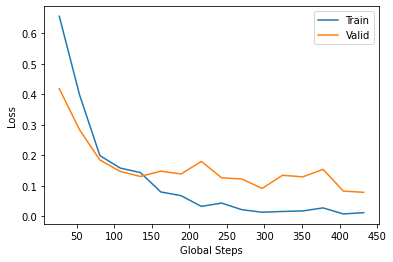

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(model_temp_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[LOAD] Model has been loaded successfully from '/content/model.pt'

SK-Learn Evaluation Result:

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        54
           0     1.0000    1.0000    1.0000        46

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100



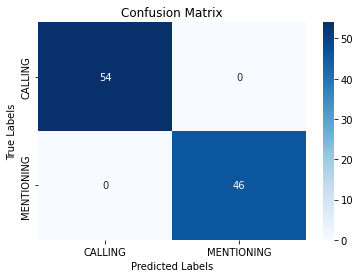

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
    print()
    print('SK-Learn Evaluation Result:')
    print()
    print(metrics.classification_report(y_true, y_pred, labels=[1, 0], digits=4))
    
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])
    ax = plt.subplot()

    seaborn.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['CALLING', 'MENTIONING'])
    ax.yaxis.set_ticklabels(['CALLING', 'MENTIONING'])
    
model_for_evaluate = ERCBCM().to(device)

load_checkpoint(model_temp_folder + '/model.pt', model_for_evaluate)

evaluate(model_for_evaluate, test_iter)

In [ ]:
def predict(model, sentence, name):
    label = torch.tensor([0])
    label = label.type(torch.LongTensor)
    label = label.to(device)
    text = tokenizer.encode(normalize_v2(sentence, name))
    text += [PAD_TOKEN_ID] * (128 - len(text))
    text = torch.tensor([text])
    text = text.type(torch.LongTensor)
    text = text.to(device)
    _, output = model(text, label)
    pred = torch.argmax(output, 1).tolist()[0]
    return 'CALLING' if pred == 1 else 'MENTIONING'

# test predicting.
predict(model_for_evaluate, 'is tommy feeling good about it?', 'tommy')

'MENTIONING'

# Finalize Training


In [ ]:
# # All things related to the finalized model should be put here.
# model_finalized = ERCBCM().to(device)
# optimizer = optim.Adam(model_finalized.parameters(), lr=2e-5)
# train(model=model_finalized, optimizer=optimizer, file_path=erc_root_folder+'/Finalized')

# ERC Live Demo - v1 (with ipywidgets)

In [ ]:
erctest_v2_input_entity = widgets.Text(value='Jimmy',
             placeholder='Type a name here.',
             description='Entity name:',
             disabled=False)
erctest_v2_input_text = widgets.Text(value='',
             placeholder='Type something here.',
             description='Sentence:',
             disabled=False)
erctest_v2_input_button = widgets.Button(description='Submit')
erctest_v2_output = widgets.Output()

widgets_display(erctest_v2_input_entity, erctest_v2_input_text, erctest_v2_input_button, erctest_v2_output)

def erctest_v2_on_button_clicked(b):
    given_sentence = erctest_v2_input_text.value
    entity_name = erctest_v2_input_entity.value
    if len(entity_name) < 1:
        entity_name = 'Jimmy'
    result = predict(model_for_evaluate, given_sentence, entity_name)
    with erctest_v2_output:
        erctest_v2_output.clear_output()
        print()
        print('Sentence:', given_sentence.lower())
        print('Target Entity:', entity_name.lower())
        print('Model Result: [{}]'.format(result))

erctest_v2_input_button.on_click(erctest_v2_on_button_clicked)

Text(value='Jimmy', description='Entity name:', placeholder='Type a name here.')

Text(value='', description='Sentence:', placeholder='Type something here.')

Button(description='Submit', style=ButtonStyle())

Output()